In [1]:
# imports required for the algorithm
import os

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# path to load and save data
data_input_path = '../../data_in/CE_Crateus.csv'
data_output_path = '../../data_out/weather.csv'
data_output_path_npsave = '../../data_out/weather.npy'

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path, output_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)
    
    dataset.drop('Precipitacao', axis=1, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
        
    # save file
    dataset.to_csv(output_path)

format_dataset(data_input_path, data_output_path)

            TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                              
2015-01-01        35.0        23.7        5.9              10.2   
2015-01-02        35.8        23.0       10.6              10.2   
2015-01-03        31.9        22.3        4.3               6.2   
2015-01-04        27.3        20.7        1.9               3.5   
2015-01-05        32.4        20.7        8.3               1.5   
...                ...         ...        ...               ...   
2018-04-26        31.0        20.8        8.9               0.5   
2018-04-27        31.7        22.9       10.5               0.5   
2018-04-28        31.3        21.5        9.5               0.5   
2018-04-29        28.9        22.7        2.5               0.5   
2018-04-30        28.9        21.9        2.5               0.5   

            Temp Comp Media  Umidade Relativa Media  Velocidade do Vento Media  
date                                           

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset(data_output_path)
values = dataset.values
features = len(dataset.columns)

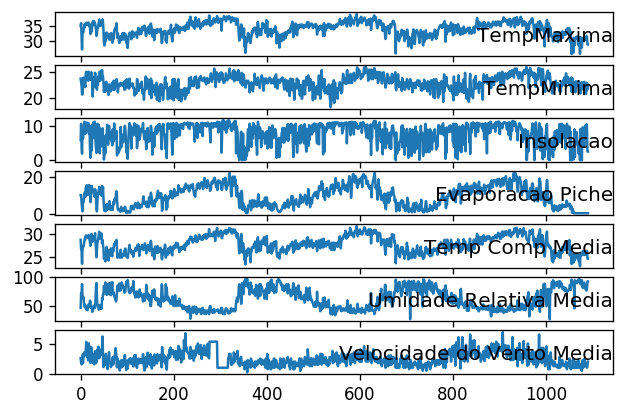

In [6]:
# plot each column in a graph
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,features)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,features)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,features)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return (x_train, y_train, x_test, y_test)

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test, scaler):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,features)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return [inv_y_hat, inv_y_test]

In [9]:
def inverseScale(model, x_test, y_test, scaler):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = scaler.inverse_transform(inv_y_hat)
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = scaler.inverse_transform(inv_y_test)
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# Nested Cross Validation
def NCV(dataset, days_to_predict, scaler):
    i = len(days_to_predict) - 1
    y_hats = []
    y_tests = []
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        result = myLSTM(x_train, y_train, x_test, y_test, scaler)
        
        y_hats += result[0].tolist()
        y_tests += result[1].tolist()
        
        i -= 1
        dataset = dataset[:-1]
        
    return [y_hats, y_tests]

In [11]:
def metrics(y_hats, y_tests):
    y_hats_max = []
    y_hats_min = []
    y_tests_max = []
    y_tests_min = []
    percentual = 100
    n = len(y_hats)
    j = 1
    
    for y in y_hats:
        y_hats_max += [y[0]]
        y_hats_min += [y[1]]
        
    for y in y_tests:
        y_tests_max += [y[0]]
        y_tests_min += [y[1]]
    
    rmse_max = sqrt(mean_squared_error(y_tests_max, y_hats_max))
    variance_max = explained_variance_score(y_tests_max, y_hats_max)
    maxError_max = max_error(y_tests_max, y_hats_max)
    meanAbsolutError_max = mean_absolute_error(y_tests_max, y_hats_max)
    medianAbsoluteError_max = median_absolute_error(y_tests_max, y_hats_max)
    
    rmse_min = sqrt(mean_squared_error(y_tests_min, y_hats_min))
    variance_min = explained_variance_score(y_tests_min, y_hats_min)
    maxError_min = max_error(y_tests_min, y_hats_min)
    meanAbsolutError_min = mean_absolute_error(y_tests_min, y_hats_min)
    medianAbsoluteError_min = median_absolute_error(y_tests_min, y_hats_min)
    
    print('Maximum metrics')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_max))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_max))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_max))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_max))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_max))
    
    print('\nAccuracy')
    while percentual > 0:
        count = 0
        n = len(y_hats_max)
        
        for i in range(0,len(y_hats_max)):
            error = abs(y_hats_max[i] - y_tests_max[i])
            if  error > j-1 and error <= j:
                count += 1
        
        percentual = round((count/n)*100,2)
        if percentual > 0:
            print('{}% of predictions missed {} point(s) or less'.format(percentual, j))
        j += 1
    
    print('\nMinimum metrics')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_min))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_min))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_min))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_min))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_min))
    
    j = 1
    percentual = 100
    print('\nAccuracy')
    while percentual > 0:
        count = 0
        n = len(y_hats_max)
        
        for i in range(0,len(y_hats_max)):
            error = abs(y_hats_min[i] - y_tests_min[i])
            if  error > j-1 and error <= j:
                count += 1
        
        percentual = round((count/n)*100,2)
        if percentual > 0:
            print('{}% of predictions missed {} point(s) or less'.format(percentual, j))
        j += 1

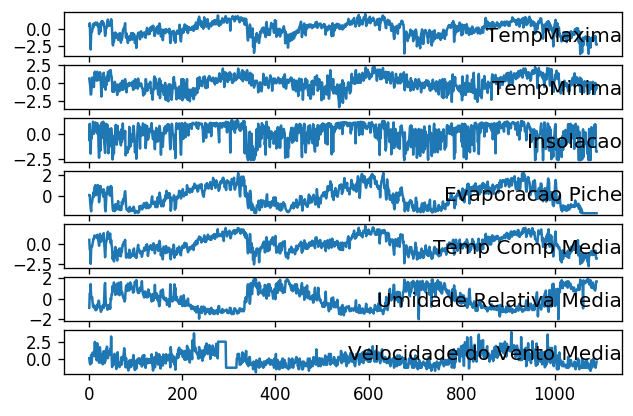

Train on 1029 samples, validate on 1 samples
Epoch 1/1000
 - 0s - loss: 0.7410 - mean_squared_error: 0.8700 - val_loss: 0.8989 - val_mean_squared_error: 1.5399
Epoch 2/1000
 - 0s - loss: 0.6164 - mean_squared_error: 0.6594 - val_loss: 0.8661 - val_mean_squared_error: 1.4898
Epoch 3/1000
 - 0s - loss: 0.5796 - mean_squared_error: 0.5843 - val_loss: 0.8936 - val_mean_squared_error: 1.5918
Epoch 4/1000
 - 0s - loss: 0.5592 - mean_squared_error: 0.5407 - val_loss: 0.9686 - val_mean_squared_error: 1.8105
Epoch 5/1000
 - 0s - loss: 0.5470 - mean_squared_error: 0.5176 - val_loss: 0.9997 - val_mean_squared_error: 1.9133
Epoch 6/1000
 - 0s - loss: 0.5358 - mean_squared_error: 0.4997 - val_loss: 1.0877 - val_mean_squared_error: 2.1351
Epoch 7/1000
 - 0s - loss: 0.5263 - mean_squared_error: 0.4840 - val_loss: 1.1753 - val_mean_squared_error: 2.4034
Epoch 8/1000
 - 0s - loss: 0.5195 - mean_squared_error: 0.4748 - val_loss: 1.1875 - val_mean_squared_error: 2.3259
Epoch 9/1000
 - 0s - loss: 0.5176 -

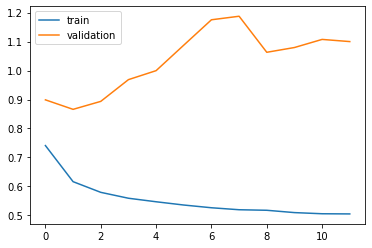


predict: [[31.88482974 22.5895709 ]]
real:      [[28.9 21.9]]

Train on 1028 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7161 - mean_squared_error: 0.8140 - val_loss: 0.7686 - val_mean_squared_error: 0.6160
Epoch 2/1000
 - 0s - loss: 0.5986 - mean_squared_error: 0.6054 - val_loss: 0.7578 - val_mean_squared_error: 0.6029
Epoch 3/1000
 - 0s - loss: 0.5698 - mean_squared_error: 0.5503 - val_loss: 0.7832 - val_mean_squared_error: 0.6347
Epoch 4/1000
 - 0s - loss: 0.5578 - mean_squared_error: 0.5300 - val_loss: 0.8363 - val_mean_squared_error: 0.7202
Epoch 5/1000
 - 0s - loss: 0.5474 - mean_squared_error: 0.5171 - val_loss: 0.8232 - val_mean_squared_error: 0.6982
Epoch 6/1000
 - 0s - loss: 0.5394 - mean_squared_error: 0.5017 - val_loss: 0.8864 - val_mean_squared_error: 0.7954
Epoch 7/1000
 - 0s - loss: 0.5406 - mean_squared_error: 0.5158 - val_loss: 0.7573 - val_mean_squared_error: 0.5911
Epoch 8/1000
 - 0s - loss: 0.5313 - mean_squared_error: 0.4906 - val_loss: 0.8142 - va

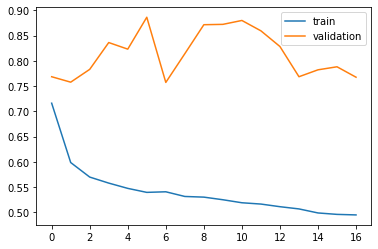


predict: [[31.6258119  22.56083297]]
real:      [[28.9 22.7]]

Train on 1027 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7535 - mean_squared_error: 0.9039 - val_loss: 0.3100 - val_mean_squared_error: 0.1069
Epoch 2/1000
 - 0s - loss: 0.6131 - mean_squared_error: 0.6423 - val_loss: 0.3238 - val_mean_squared_error: 0.1280
Epoch 3/1000
 - 0s - loss: 0.5733 - mean_squared_error: 0.5625 - val_loss: 0.2770 - val_mean_squared_error: 0.1215
Epoch 4/1000
 - 0s - loss: 0.5528 - mean_squared_error: 0.5326 - val_loss: 0.3701 - val_mean_squared_error: 0.1942
Epoch 5/1000
 - 0s - loss: 0.5420 - mean_squared_error: 0.5158 - val_loss: 0.3908 - val_mean_squared_error: 0.2290
Epoch 6/1000
 - 0s - loss: 0.5341 - mean_squared_error: 0.5044 - val_loss: 0.4117 - val_mean_squared_error: 0.2482
Epoch 7/1000
 - 0s - loss: 0.5291 - mean_squared_error: 0.4922 - val_loss: 0.4280 - val_mean_squared_error: 0.2600
Epoch 8/1000
 - 0s - loss: 0.5244 - mean_squared_error: 0.4800 - val_loss: 0.3425 - va

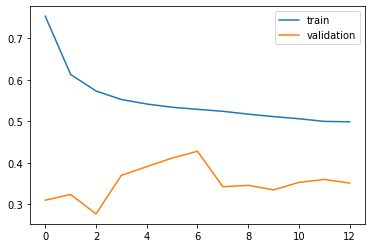


predict: [[31.94617981 22.69086288]]
real:      [[31.3 21.5]]

Train on 1026 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7669 - mean_squared_error: 0.9195 - val_loss: 1.2698 - val_mean_squared_error: 1.6476
Epoch 2/1000
 - 0s - loss: 0.6424 - mean_squared_error: 0.6700 - val_loss: 1.1274 - val_mean_squared_error: 1.4127
Epoch 3/1000
 - 0s - loss: 0.5736 - mean_squared_error: 0.5544 - val_loss: 1.0002 - val_mean_squared_error: 1.2308
Epoch 4/1000
 - 0s - loss: 0.5577 - mean_squared_error: 0.5305 - val_loss: 1.0806 - val_mean_squared_error: 1.3462
Epoch 5/1000
 - 0s - loss: 0.5409 - mean_squared_error: 0.5086 - val_loss: 1.0588 - val_mean_squared_error: 1.2861
Epoch 6/1000
 - 0s - loss: 0.5356 - mean_squared_error: 0.4979 - val_loss: 1.0923 - val_mean_squared_error: 1.2962
Epoch 7/1000
 - 0s - loss: 0.5296 - mean_squared_error: 0.4933 - val_loss: 1.1083 - val_mean_squared_error: 1.2918
Epoch 8/1000
 - 0s - loss: 0.5250 - mean_squared_error: 0.4833 - val_loss: 1.1798 - va

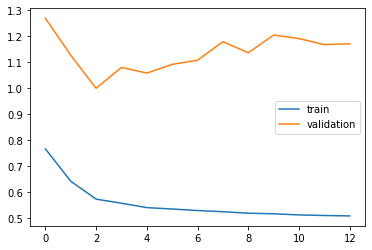


predict: [[31.92247631 22.76550353]]
real:      [[31.7 22.9]]

Train on 1025 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7715 - mean_squared_error: 0.9348 - val_loss: 1.1848 - val_mean_squared_error: 1.4219
Epoch 2/1000
 - 0s - loss: 0.6670 - mean_squared_error: 0.7064 - val_loss: 1.0809 - val_mean_squared_error: 1.1935
Epoch 3/1000
 - 0s - loss: 0.5788 - mean_squared_error: 0.5700 - val_loss: 1.0485 - val_mean_squared_error: 1.1174
Epoch 4/1000
 - 0s - loss: 0.5601 - mean_squared_error: 0.5348 - val_loss: 1.0877 - val_mean_squared_error: 1.1982
Epoch 5/1000
 - 0s - loss: 0.5442 - mean_squared_error: 0.5128 - val_loss: 1.1362 - val_mean_squared_error: 1.3036
Epoch 6/1000
 - 0s - loss: 0.5408 - mean_squared_error: 0.5059 - val_loss: 1.1434 - val_mean_squared_error: 1.3129
Epoch 7/1000
 - 0s - loss: 0.5316 - mean_squared_error: 0.4957 - val_loss: 1.2349 - val_mean_squared_error: 1.5278
Epoch 8/1000
 - 0s - loss: 0.5245 - mean_squared_error: 0.4863 - val_loss: 1.1912 - va

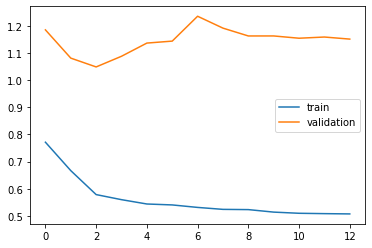


predict: [[31.94564048 22.64906171]]
real:      [[31.  20.8]]

Train on 1024 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7207 - mean_squared_error: 0.8339 - val_loss: 0.9302 - val_mean_squared_error: 0.8858
Epoch 2/1000
 - 0s - loss: 0.6145 - mean_squared_error: 0.6234 - val_loss: 0.8409 - val_mean_squared_error: 0.7169
Epoch 3/1000
 - 0s - loss: 0.5620 - mean_squared_error: 0.5436 - val_loss: 0.8225 - val_mean_squared_error: 0.6894
Epoch 4/1000
 - 0s - loss: 0.5459 - mean_squared_error: 0.5207 - val_loss: 0.8682 - val_mean_squared_error: 0.7766
Epoch 5/1000
 - 0s - loss: 0.5398 - mean_squared_error: 0.5077 - val_loss: 0.8392 - val_mean_squared_error: 0.7321
Epoch 6/1000
 - 0s - loss: 0.5376 - mean_squared_error: 0.5038 - val_loss: 0.8766 - val_mean_squared_error: 0.8180
Epoch 7/1000
 - 0s - loss: 0.5388 - mean_squared_error: 0.5072 - val_loss: 0.9339 - val_mean_squared_error: 0.9680
Epoch 8/1000
 - 0s - loss: 0.5256 - mean_squared_error: 0.4845 - val_loss: 0.9528 - va

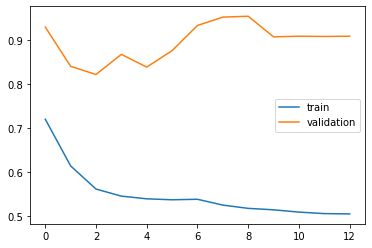


predict: [[32.09204839 22.58652278]]
real:      [[30.7 21. ]]

Train on 1023 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7478 - mean_squared_error: 0.8663 - val_loss: 0.9023 - val_mean_squared_error: 1.1208
Epoch 2/1000
 - 0s - loss: 0.6281 - mean_squared_error: 0.6389 - val_loss: 0.7597 - val_mean_squared_error: 0.6928
Epoch 3/1000
 - 0s - loss: 0.5638 - mean_squared_error: 0.5481 - val_loss: 0.8081 - val_mean_squared_error: 0.8812
Epoch 4/1000
 - 0s - loss: 0.5446 - mean_squared_error: 0.5187 - val_loss: 0.8241 - val_mean_squared_error: 0.9293
Epoch 5/1000
 - 0s - loss: 0.5390 - mean_squared_error: 0.5047 - val_loss: 0.8728 - val_mean_squared_error: 1.0699
Epoch 6/1000
 - 0s - loss: 0.5288 - mean_squared_error: 0.4904 - val_loss: 0.7832 - val_mean_squared_error: 0.9282
Epoch 7/1000
 - 0s - loss: 0.5244 - mean_squared_error: 0.4827 - val_loss: 0.8374 - val_mean_squared_error: 1.0674
Epoch 8/1000
 - 0s - loss: 0.5218 - mean_squared_error: 0.4777 - val_loss: 0.6962 - va

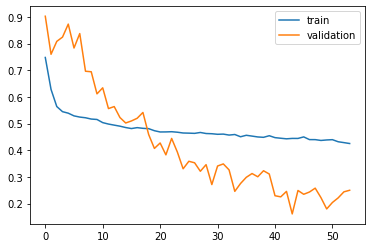


predict: [[32.00164196 22.47493498]]
real:      [[30.6 21.7]]

Train on 1022 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7551 - mean_squared_error: 0.8938 - val_loss: 0.7307 - val_mean_squared_error: 0.7358
Epoch 2/1000
 - 0s - loss: 0.6732 - mean_squared_error: 0.7440 - val_loss: 0.7124 - val_mean_squared_error: 0.7632
Epoch 3/1000
 - 0s - loss: 0.6130 - mean_squared_error: 0.6259 - val_loss: 0.7797 - val_mean_squared_error: 0.8331
Epoch 4/1000
 - 0s - loss: 0.5684 - mean_squared_error: 0.5533 - val_loss: 0.7614 - val_mean_squared_error: 0.8349
Epoch 5/1000
 - 0s - loss: 0.5563 - mean_squared_error: 0.5314 - val_loss: 0.7371 - val_mean_squared_error: 0.7732
Epoch 6/1000
 - 0s - loss: 0.5399 - mean_squared_error: 0.5075 - val_loss: 0.7530 - val_mean_squared_error: 0.8669
Epoch 7/1000
 - 0s - loss: 0.5341 - mean_squared_error: 0.4988 - val_loss: 0.7814 - val_mean_squared_error: 0.8904
Epoch 8/1000
 - 0s - loss: 0.5311 - mean_squared_error: 0.4949 - val_loss: 0.8210 - va

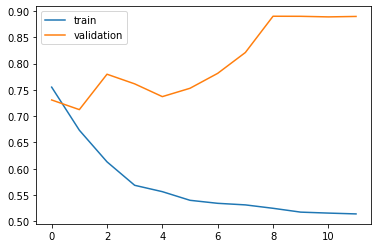


predict: [[32.04575815 22.67600202]]
real:      [[30.3 22.3]]

Train on 1021 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7433 - mean_squared_error: 0.8736 - val_loss: 0.5459 - val_mean_squared_error: 0.4209
Epoch 2/1000
 - 0s - loss: 0.6217 - mean_squared_error: 0.6482 - val_loss: 0.3456 - val_mean_squared_error: 0.2283
Epoch 3/1000
 - 0s - loss: 0.5739 - mean_squared_error: 0.5597 - val_loss: 0.3477 - val_mean_squared_error: 0.1874
Epoch 4/1000
 - 0s - loss: 0.5550 - mean_squared_error: 0.5318 - val_loss: 0.3753 - val_mean_squared_error: 0.2454
Epoch 5/1000
 - 0s - loss: 0.5437 - mean_squared_error: 0.5200 - val_loss: 0.3615 - val_mean_squared_error: 0.2280
Epoch 6/1000
 - 0s - loss: 0.5424 - mean_squared_error: 0.5181 - val_loss: 0.3646 - val_mean_squared_error: 0.2360
Epoch 7/1000
 - 0s - loss: 0.5368 - mean_squared_error: 0.5096 - val_loss: 0.4519 - val_mean_squared_error: 0.3138
Epoch 8/1000
 - 0s - loss: 0.5285 - mean_squared_error: 0.4962 - val_loss: 0.4362 - va

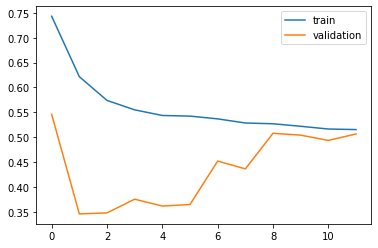


predict: [[32.05728424 22.67417383]]
real:      [[30.  23.1]]

Train on 1020 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7252 - mean_squared_error: 0.8553 - val_loss: 0.5417 - val_mean_squared_error: 0.2968
Epoch 2/1000
 - 0s - loss: 0.6166 - mean_squared_error: 0.6358 - val_loss: 0.6185 - val_mean_squared_error: 0.4261
Epoch 3/1000
 - 0s - loss: 0.5725 - mean_squared_error: 0.5570 - val_loss: 0.5520 - val_mean_squared_error: 0.3506
Epoch 4/1000
 - 0s - loss: 0.5519 - mean_squared_error: 0.5262 - val_loss: 0.5889 - val_mean_squared_error: 0.4097
Epoch 5/1000
 - 0s - loss: 0.5408 - mean_squared_error: 0.5150 - val_loss: 0.7096 - val_mean_squared_error: 0.5795
Epoch 6/1000
 - 0s - loss: 0.5400 - mean_squared_error: 0.5126 - val_loss: 0.6074 - val_mean_squared_error: 0.4523
Epoch 7/1000
 - 0s - loss: 0.5269 - mean_squared_error: 0.4947 - val_loss: 0.6627 - val_mean_squared_error: 0.5449
Epoch 8/1000
 - 0s - loss: 0.5228 - mean_squared_error: 0.4854 - val_loss: 0.5894 - va

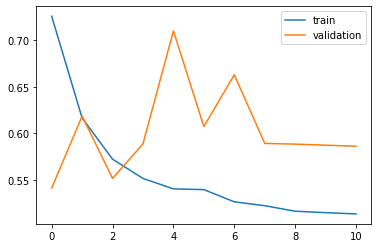


predict: [[31.75372606 22.79583863]]
real:      [[31.1 22.8]]

Train on 1019 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7161 - mean_squared_error: 0.8109 - val_loss: 0.4369 - val_mean_squared_error: 0.3583
Epoch 2/1000
 - 0s - loss: 0.6175 - mean_squared_error: 0.6308 - val_loss: 0.3875 - val_mean_squared_error: 0.2518
Epoch 3/1000
 - 0s - loss: 0.5767 - mean_squared_error: 0.5633 - val_loss: 0.4527 - val_mean_squared_error: 0.3413
Epoch 4/1000
 - 0s - loss: 0.5594 - mean_squared_error: 0.5386 - val_loss: 0.4404 - val_mean_squared_error: 0.3504
Epoch 5/1000
 - 0s - loss: 0.5473 - mean_squared_error: 0.5243 - val_loss: 0.4658 - val_mean_squared_error: 0.4112
Epoch 6/1000
 - 0s - loss: 0.5421 - mean_squared_error: 0.5130 - val_loss: 0.4741 - val_mean_squared_error: 0.4463
Epoch 7/1000
 - 0s - loss: 0.5370 - mean_squared_error: 0.5078 - val_loss: 0.4841 - val_mean_squared_error: 0.4642
Epoch 8/1000
 - 0s - loss: 0.5338 - mean_squared_error: 0.5049 - val_loss: 0.4606 - va

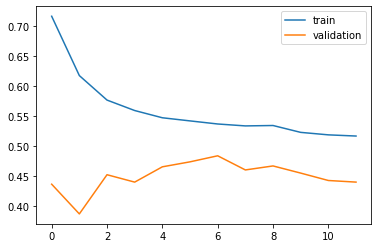


predict: [[31.93610121 22.64861449]]
real:      [[31.1 22.3]]

Train on 1018 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7526 - mean_squared_error: 0.9164 - val_loss: 0.9430 - val_mean_squared_error: 0.8898
Epoch 2/1000
 - 0s - loss: 0.6320 - mean_squared_error: 0.6774 - val_loss: 0.8479 - val_mean_squared_error: 0.7192
Epoch 3/1000
 - 0s - loss: 0.5952 - mean_squared_error: 0.6044 - val_loss: 0.7815 - val_mean_squared_error: 0.6120
Epoch 4/1000
 - 0s - loss: 0.5661 - mean_squared_error: 0.5580 - val_loss: 0.8558 - val_mean_squared_error: 0.7385
Epoch 5/1000
 - 0s - loss: 0.5488 - mean_squared_error: 0.5354 - val_loss: 0.8323 - val_mean_squared_error: 0.7000
Epoch 6/1000
 - 0s - loss: 0.5409 - mean_squared_error: 0.5198 - val_loss: 0.7969 - val_mean_squared_error: 0.6355
Epoch 7/1000
 - 0s - loss: 0.5367 - mean_squared_error: 0.5131 - val_loss: 0.7885 - val_mean_squared_error: 0.6249
Epoch 8/1000
 - 0s - loss: 0.5292 - mean_squared_error: 0.5019 - val_loss: 0.7750 - va

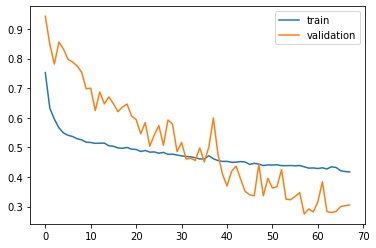


predict: [[31.26353938 21.71947657]]
real:      [[31.  22.8]]

Train on 1017 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7197 - mean_squared_error: 0.8148 - val_loss: 1.2532 - val_mean_squared_error: 2.4648
Epoch 2/1000
 - 0s - loss: 0.6005 - mean_squared_error: 0.6153 - val_loss: 1.1017 - val_mean_squared_error: 2.1416
Epoch 3/1000
 - 0s - loss: 0.5678 - mean_squared_error: 0.5543 - val_loss: 1.1109 - val_mean_squared_error: 2.2870
Epoch 4/1000
 - 0s - loss: 0.5468 - mean_squared_error: 0.5281 - val_loss: 1.1587 - val_mean_squared_error: 2.2854
Epoch 5/1000
 - 0s - loss: 0.5381 - mean_squared_error: 0.5131 - val_loss: 1.1210 - val_mean_squared_error: 2.1652
Epoch 6/1000
 - 0s - loss: 0.5356 - mean_squared_error: 0.5097 - val_loss: 1.1545 - val_mean_squared_error: 2.2666
Epoch 7/1000
 - 0s - loss: 0.5296 - mean_squared_error: 0.5011 - val_loss: 1.1549 - val_mean_squared_error: 2.1300
Epoch 8/1000
 - 0s - loss: 0.5271 - mean_squared_error: 0.4946 - val_loss: 1.1880 - va

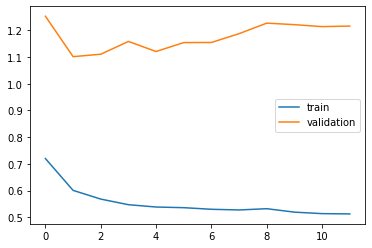


predict: [[32.00229675 22.67199685]]
real:      [[30.7 21.7]]

Train on 1016 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7770 - mean_squared_error: 0.9353 - val_loss: 0.9258 - val_mean_squared_error: 1.6498
Epoch 2/1000
 - 0s - loss: 0.6511 - mean_squared_error: 0.6986 - val_loss: 0.8342 - val_mean_squared_error: 1.2876
Epoch 3/1000
 - 0s - loss: 0.5738 - mean_squared_error: 0.5697 - val_loss: 0.8027 - val_mean_squared_error: 1.1097
Epoch 4/1000
 - 0s - loss: 0.5553 - mean_squared_error: 0.5295 - val_loss: 0.7711 - val_mean_squared_error: 0.9652
Epoch 5/1000
 - 0s - loss: 0.5429 - mean_squared_error: 0.5167 - val_loss: 0.7839 - val_mean_squared_error: 1.0375
Epoch 6/1000
 - 0s - loss: 0.5373 - mean_squared_error: 0.5081 - val_loss: 0.8159 - val_mean_squared_error: 1.0260
Epoch 7/1000
 - 0s - loss: 0.5319 - mean_squared_error: 0.4967 - val_loss: 0.8551 - val_mean_squared_error: 1.1591
Epoch 8/1000
 - 0s - loss: 0.5306 - mean_squared_error: 0.5044 - val_loss: 0.8633 - va

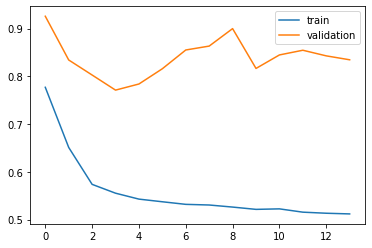


predict: [[31.93260355 22.64197063]]
real:      [[27.9 23. ]]

Train on 1015 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7111 - mean_squared_error: 0.8109 - val_loss: 0.9188 - val_mean_squared_error: 0.8696
Epoch 2/1000
 - 0s - loss: 0.5912 - mean_squared_error: 0.5926 - val_loss: 0.8171 - val_mean_squared_error: 0.6740
Epoch 3/1000
 - 0s - loss: 0.5742 - mean_squared_error: 0.5717 - val_loss: 0.8376 - val_mean_squared_error: 0.7191
Epoch 4/1000
 - 0s - loss: 0.5567 - mean_squared_error: 0.5347 - val_loss: 0.9004 - val_mean_squared_error: 0.8242
Epoch 5/1000
 - 0s - loss: 0.5378 - mean_squared_error: 0.5101 - val_loss: 0.8672 - val_mean_squared_error: 0.7693
Epoch 6/1000
 - 0s - loss: 0.5318 - mean_squared_error: 0.4975 - val_loss: 0.8311 - val_mean_squared_error: 0.7344
Epoch 7/1000
 - 0s - loss: 0.5261 - mean_squared_error: 0.4890 - val_loss: 0.7272 - val_mean_squared_error: 0.6028
Epoch 8/1000
 - 0s - loss: 0.5188 - mean_squared_error: 0.4735 - val_loss: 0.6713 - va

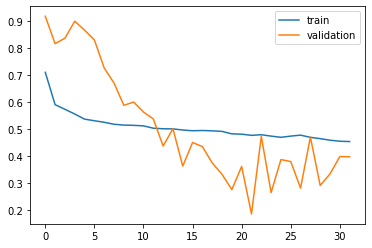


predict: [[32.30562736 22.6893654 ]]
real:      [[29.5 23. ]]

Train on 1014 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7965 - mean_squared_error: 0.9673 - val_loss: 1.0200 - val_mean_squared_error: 1.1132
Epoch 2/1000
 - 0s - loss: 0.6449 - mean_squared_error: 0.6844 - val_loss: 1.1414 - val_mean_squared_error: 1.4767
Epoch 3/1000
 - 0s - loss: 0.5827 - mean_squared_error: 0.5845 - val_loss: 1.0270 - val_mean_squared_error: 1.2361
Epoch 4/1000
 - 0s - loss: 0.5531 - mean_squared_error: 0.5293 - val_loss: 1.1337 - val_mean_squared_error: 1.4016
Epoch 5/1000
 - 0s - loss: 0.5408 - mean_squared_error: 0.5086 - val_loss: 1.1106 - val_mean_squared_error: 1.3288
Epoch 6/1000
 - 0s - loss: 0.5339 - mean_squared_error: 0.4975 - val_loss: 1.0493 - val_mean_squared_error: 1.1621
Epoch 7/1000
 - 0s - loss: 0.5469 - mean_squared_error: 0.5233 - val_loss: 1.0914 - val_mean_squared_error: 1.2621
Epoch 8/1000
 - 0s - loss: 0.5362 - mean_squared_error: 0.4946 - val_loss: 1.0258 - va

 - 0s - loss: 0.4876 - mean_squared_error: 0.4276 - val_loss: 0.7046 - val_mean_squared_error: 0.6276
Epoch 71/1000
 - 0s - loss: 0.4869 - mean_squared_error: 0.4282 - val_loss: 0.6961 - val_mean_squared_error: 0.6083
Epoch 72/1000
 - 0s - loss: 0.4869 - mean_squared_error: 0.4287 - val_loss: 0.6772 - val_mean_squared_error: 0.5805
Epoch 73/1000
 - 0s - loss: 0.4861 - mean_squared_error: 0.4262 - val_loss: 0.6840 - val_mean_squared_error: 0.5930
Epoch 74/1000
 - 0s - loss: 0.4868 - mean_squared_error: 0.4260 - val_loss: 0.6850 - val_mean_squared_error: 0.6130
Epoch 75/1000
 - 0s - loss: 0.4857 - mean_squared_error: 0.4243 - val_loss: 0.6867 - val_mean_squared_error: 0.6095
Epoch 76/1000
 - 0s - loss: 0.4858 - mean_squared_error: 0.4266 - val_loss: 0.6771 - val_mean_squared_error: 0.5800
Epoch 77/1000
 - 0s - loss: 0.4849 - mean_squared_error: 0.4238 - val_loss: 0.6606 - val_mean_squared_error: 0.5605
Epoch 78/1000
 - 0s - loss: 0.4844 - mean_squared_error: 0.4225 - val_loss: 0.6508 - v

Epoch 141/1000
 - 0s - loss: 0.4586 - mean_squared_error: 0.3929 - val_loss: 0.4130 - val_mean_squared_error: 0.3357
Epoch 142/1000
 - 0s - loss: 0.4583 - mean_squared_error: 0.3926 - val_loss: 0.4217 - val_mean_squared_error: 0.3431
Epoch 143/1000
 - 0s - loss: 0.4587 - mean_squared_error: 0.3889 - val_loss: 0.4283 - val_mean_squared_error: 0.3347
Epoch 144/1000
 - 0s - loss: 0.4576 - mean_squared_error: 0.3897 - val_loss: 0.4290 - val_mean_squared_error: 0.3464
Epoch 145/1000
 - 0s - loss: 0.4573 - mean_squared_error: 0.3884 - val_loss: 0.4257 - val_mean_squared_error: 0.3360
Epoch 146/1000
 - 0s - loss: 0.4570 - mean_squared_error: 0.3891 - val_loss: 0.4184 - val_mean_squared_error: 0.3376
Epoch 147/1000
 - 0s - loss: 0.4571 - mean_squared_error: 0.3894 - val_loss: 0.4305 - val_mean_squared_error: 0.3485
Epoch 148/1000
 - 0s - loss: 0.4571 - mean_squared_error: 0.3908 - val_loss: 0.4190 - val_mean_squared_error: 0.3302

Epoch 00148: ReduceLROnPlateau reducing learning rate to 1.0000

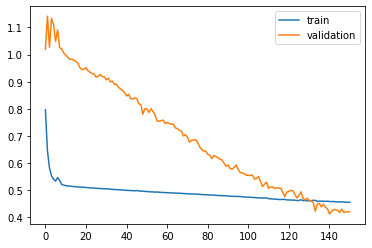


predict: [[31.7523502  22.24052816]]
real:      [[30.7 21.8]]

Train on 1013 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7162 - mean_squared_error: 0.8331 - val_loss: 2.1448 - val_mean_squared_error: 5.5521
Epoch 2/1000
 - 0s - loss: 0.6158 - mean_squared_error: 0.6450 - val_loss: 2.0723 - val_mean_squared_error: 5.0638
Epoch 3/1000
 - 0s - loss: 0.5666 - mean_squared_error: 0.5581 - val_loss: 2.0122 - val_mean_squared_error: 4.8377
Epoch 4/1000
 - 0s - loss: 0.5409 - mean_squared_error: 0.5116 - val_loss: 2.0266 - val_mean_squared_error: 4.9979
Epoch 5/1000
 - 0s - loss: 0.5324 - mean_squared_error: 0.4976 - val_loss: 2.0561 - val_mean_squared_error: 5.1674
Epoch 6/1000
 - 0s - loss: 0.5280 - mean_squared_error: 0.4915 - val_loss: 2.1097 - val_mean_squared_error: 5.4594
Epoch 7/1000
 - 0s - loss: 0.5224 - mean_squared_error: 0.4847 - val_loss: 2.0776 - val_mean_squared_error: 5.3779
Epoch 8/1000
 - 0s - loss: 0.5179 - mean_squared_error: 0.4764 - val_loss: 2.0606 - va

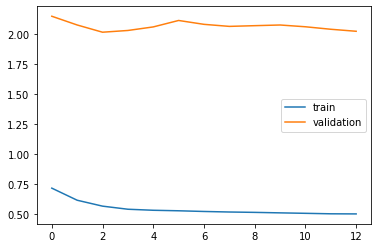


predict: [[32.2520128  22.45855019]]
real:      [[31.3 20.9]]

Train on 1012 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7357 - mean_squared_error: 0.8499 - val_loss: 1.5858 - val_mean_squared_error: 2.5998
Epoch 2/1000
 - 0s - loss: 0.6068 - mean_squared_error: 0.6130 - val_loss: 1.4424 - val_mean_squared_error: 2.1237
Epoch 3/1000
 - 0s - loss: 0.5618 - mean_squared_error: 0.5453 - val_loss: 1.3881 - val_mean_squared_error: 1.9553
Epoch 4/1000
 - 0s - loss: 0.5403 - mean_squared_error: 0.5071 - val_loss: 1.4343 - val_mean_squared_error: 2.0888
Epoch 5/1000
 - 0s - loss: 0.5318 - mean_squared_error: 0.4880 - val_loss: 1.3370 - val_mean_squared_error: 1.8042
Epoch 6/1000
 - 0s - loss: 0.5214 - mean_squared_error: 0.4809 - val_loss: 1.3573 - val_mean_squared_error: 1.8931
Epoch 7/1000
 - 0s - loss: 0.5184 - mean_squared_error: 0.4666 - val_loss: 1.3099 - val_mean_squared_error: 1.7624
Epoch 8/1000
 - 0s - loss: 0.5134 - mean_squared_error: 0.4625 - val_loss: 1.3794 - va

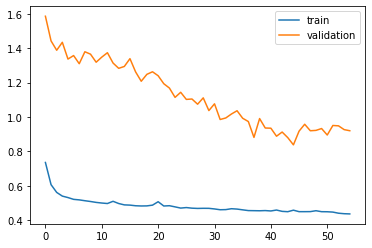


predict: [[33.10000737 22.61622276]]
real:      [[25.9 21.2]]

Train on 1011 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7299 - mean_squared_error: 0.8301 - val_loss: 1.0318 - val_mean_squared_error: 1.0647
Epoch 2/1000
 - 0s - loss: 0.6330 - mean_squared_error: 0.6533 - val_loss: 0.9736 - val_mean_squared_error: 0.9481
Epoch 3/1000
 - 0s - loss: 0.5776 - mean_squared_error: 0.5627 - val_loss: 0.7774 - val_mean_squared_error: 0.6049
Epoch 4/1000
 - 0s - loss: 0.5482 - mean_squared_error: 0.5125 - val_loss: 0.6952 - val_mean_squared_error: 0.4883
Epoch 5/1000
 - 0s - loss: 0.5331 - mean_squared_error: 0.4890 - val_loss: 0.7677 - val_mean_squared_error: 0.5910
Epoch 6/1000
 - 0s - loss: 0.5281 - mean_squared_error: 0.4871 - val_loss: 0.7787 - val_mean_squared_error: 0.6066
Epoch 7/1000
 - 0s - loss: 0.5234 - mean_squared_error: 0.4765 - val_loss: 0.6923 - val_mean_squared_error: 0.4862
Epoch 8/1000
 - 0s - loss: 0.5237 - mean_squared_error: 0.4742 - val_loss: 0.7495 - va

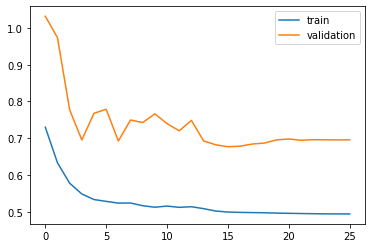


predict: [[32.26226017 22.71711421]]
real:      [[29.2 21.1]]

Train on 1010 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7571 - mean_squared_error: 0.8800 - val_loss: 0.9024 - val_mean_squared_error: 1.2693
Epoch 2/1000
 - 0s - loss: 0.7167 - mean_squared_error: 0.7985 - val_loss: 1.0376 - val_mean_squared_error: 1.7689
Epoch 3/1000
 - 0s - loss: 0.6818 - mean_squared_error: 0.7340 - val_loss: 0.9901 - val_mean_squared_error: 1.5249
Epoch 4/1000
 - 0s - loss: 0.6134 - mean_squared_error: 0.6173 - val_loss: 1.0157 - val_mean_squared_error: 1.5613
Epoch 5/1000
 - 0s - loss: 0.5538 - mean_squared_error: 0.5299 - val_loss: 1.0676 - val_mean_squared_error: 1.5882
Epoch 6/1000
 - 0s - loss: 0.5420 - mean_squared_error: 0.4980 - val_loss: 1.1541 - val_mean_squared_error: 1.7799
Epoch 7/1000
 - 0s - loss: 0.5313 - mean_squared_error: 0.4938 - val_loss: 1.0268 - val_mean_squared_error: 1.5206
Epoch 8/1000
 - 0s - loss: 0.5267 - mean_squared_error: 0.4855 - val_loss: 1.0938 - va

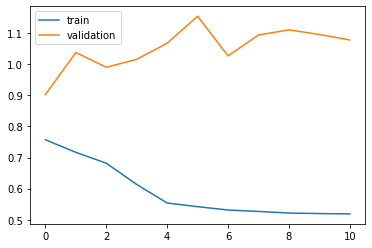


predict: [[31.67797055 22.68171034]]
real:      [[31.1 21.7]]

Train on 1009 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7413 - mean_squared_error: 0.8737 - val_loss: 0.4747 - val_mean_squared_error: 0.2351
Epoch 2/1000
 - 0s - loss: 0.6274 - mean_squared_error: 0.6466 - val_loss: 0.5909 - val_mean_squared_error: 0.3871
Epoch 3/1000
 - 0s - loss: 0.5698 - mean_squared_error: 0.5545 - val_loss: 0.5292 - val_mean_squared_error: 0.3016
Epoch 4/1000
 - 0s - loss: 0.5477 - mean_squared_error: 0.5094 - val_loss: 0.5876 - val_mean_squared_error: 0.3530
Epoch 5/1000
 - 0s - loss: 0.5372 - mean_squared_error: 0.4977 - val_loss: 0.5305 - val_mean_squared_error: 0.3038
Epoch 6/1000
 - 0s - loss: 0.5258 - mean_squared_error: 0.4792 - val_loss: 0.4984 - val_mean_squared_error: 0.2859
Epoch 7/1000
 - 0s - loss: 0.5194 - mean_squared_error: 0.4692 - val_loss: 0.5268 - val_mean_squared_error: 0.3216
Epoch 8/1000
 - 0s - loss: 0.5198 - mean_squared_error: 0.4725 - val_loss: 0.5243 - va

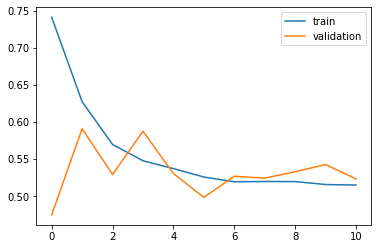


predict: [[31.62302328 22.65601279]]
real:      [[28.7 23.2]]

Train on 1008 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7581 - mean_squared_error: 0.8887 - val_loss: 0.5714 - val_mean_squared_error: 0.3275
Epoch 2/1000
 - 0s - loss: 0.6582 - mean_squared_error: 0.7042 - val_loss: 0.6175 - val_mean_squared_error: 0.3903
Epoch 3/1000
 - 0s - loss: 0.5816 - mean_squared_error: 0.5825 - val_loss: 0.5553 - val_mean_squared_error: 0.3301
Epoch 4/1000
 - 0s - loss: 0.5457 - mean_squared_error: 0.5222 - val_loss: 0.5859 - val_mean_squared_error: 0.4084
Epoch 5/1000
 - 0s - loss: 0.5322 - mean_squared_error: 0.4965 - val_loss: 0.5709 - val_mean_squared_error: 0.3462
Epoch 6/1000
 - 0s - loss: 0.5226 - mean_squared_error: 0.4805 - val_loss: 0.5530 - val_mean_squared_error: 0.3574
Epoch 7/1000
 - 0s - loss: 0.5157 - mean_squared_error: 0.4698 - val_loss: 0.5235 - val_mean_squared_error: 0.3114
Epoch 8/1000
 - 0s - loss: 0.5118 - mean_squared_error: 0.4620 - val_loss: 0.4342 - va

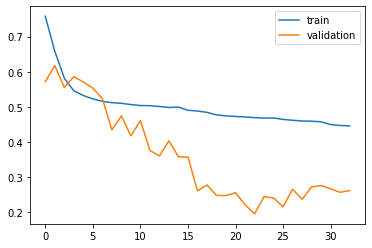


predict: [[32.00113336 22.73331308]]
real:      [[31.2 22.3]]

Train on 1007 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7449 - mean_squared_error: 0.8851 - val_loss: 0.5976 - val_mean_squared_error: 0.5459
Epoch 2/1000
 - 0s - loss: 0.6174 - mean_squared_error: 0.6386 - val_loss: 0.4155 - val_mean_squared_error: 0.3401
Epoch 3/1000
 - 0s - loss: 0.5687 - mean_squared_error: 0.5449 - val_loss: 0.4464 - val_mean_squared_error: 0.2804
Epoch 4/1000
 - 0s - loss: 0.5462 - mean_squared_error: 0.5106 - val_loss: 0.4343 - val_mean_squared_error: 0.3232
Epoch 5/1000
 - 0s - loss: 0.5329 - mean_squared_error: 0.4924 - val_loss: 0.4663 - val_mean_squared_error: 0.3857
Epoch 6/1000
 - 0s - loss: 0.5267 - mean_squared_error: 0.4871 - val_loss: 0.4422 - val_mean_squared_error: 0.3161
Epoch 7/1000
 - 0s - loss: 0.5221 - mean_squared_error: 0.4776 - val_loss: 0.3917 - val_mean_squared_error: 0.2667
Epoch 8/1000
 - 0s - loss: 0.5142 - mean_squared_error: 0.4640 - val_loss: 0.4478 - va

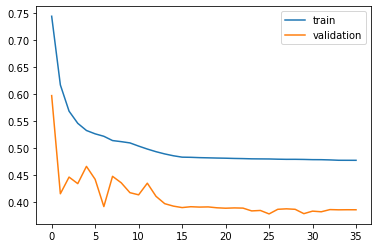


predict: [[32.02121492 22.74493848]]
real:      [[31.1 22.3]]

Train on 1006 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7231 - mean_squared_error: 0.8352 - val_loss: 0.4911 - val_mean_squared_error: 0.2845
Epoch 2/1000
 - 0s - loss: 0.5993 - mean_squared_error: 0.5957 - val_loss: 0.3673 - val_mean_squared_error: 0.1685
Epoch 3/1000
 - 0s - loss: 0.5603 - mean_squared_error: 0.5317 - val_loss: 0.3666 - val_mean_squared_error: 0.1501
Epoch 4/1000
 - 0s - loss: 0.5385 - mean_squared_error: 0.5009 - val_loss: 0.3510 - val_mean_squared_error: 0.1337
Epoch 5/1000
 - 0s - loss: 0.5246 - mean_squared_error: 0.4801 - val_loss: 0.3592 - val_mean_squared_error: 0.1459
Epoch 6/1000
 - 0s - loss: 0.5173 - mean_squared_error: 0.4745 - val_loss: 0.3684 - val_mean_squared_error: 0.1519
Epoch 7/1000
 - 0s - loss: 0.5167 - mean_squared_error: 0.4755 - val_loss: 0.3630 - val_mean_squared_error: 0.1375
Epoch 8/1000
 - 0s - loss: 0.5091 - mean_squared_error: 0.4630 - val_loss: 0.3666 - va

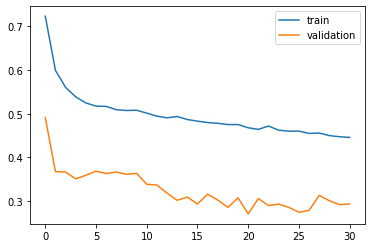


predict: [[31.77299795 22.62054942]]
real:      [[31.  22.8]]

Train on 1005 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7320 - mean_squared_error: 0.8626 - val_loss: 0.4417 - val_mean_squared_error: 0.3033
Epoch 2/1000
 - 0s - loss: 0.6263 - mean_squared_error: 0.6668 - val_loss: 0.4212 - val_mean_squared_error: 0.3478
Epoch 3/1000
 - 0s - loss: 0.5801 - mean_squared_error: 0.5899 - val_loss: 0.4343 - val_mean_squared_error: 0.2532
Epoch 4/1000
 - 0s - loss: 0.5536 - mean_squared_error: 0.5403 - val_loss: 0.4514 - val_mean_squared_error: 0.2659
Epoch 5/1000
 - 0s - loss: 0.5407 - mean_squared_error: 0.5220 - val_loss: 0.4832 - val_mean_squared_error: 0.2924
Epoch 6/1000
 - 0s - loss: 0.5359 - mean_squared_error: 0.5112 - val_loss: 0.4089 - val_mean_squared_error: 0.2329
Epoch 7/1000
 - 0s - loss: 0.5285 - mean_squared_error: 0.4988 - val_loss: 0.4106 - val_mean_squared_error: 0.2259
Epoch 8/1000
 - 0s - loss: 0.5231 - mean_squared_error: 0.4829 - val_loss: 0.4418 - va

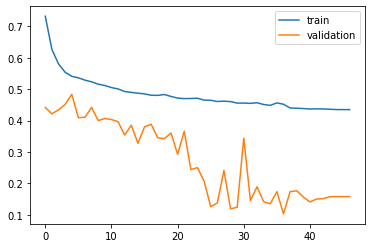


predict: [[31.54189072 22.56786056]]
real:      [[31.5 23. ]]

Train on 1004 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7850 - mean_squared_error: 0.9458 - val_loss: 0.5592 - val_mean_squared_error: 0.3911
Epoch 2/1000
 - 0s - loss: 0.6908 - mean_squared_error: 0.7481 - val_loss: 0.4433 - val_mean_squared_error: 0.2129
Epoch 3/1000
 - 0s - loss: 0.6305 - mean_squared_error: 0.6351 - val_loss: 0.4192 - val_mean_squared_error: 0.1864
Epoch 4/1000
 - 0s - loss: 0.5597 - mean_squared_error: 0.5284 - val_loss: 0.4026 - val_mean_squared_error: 0.1623
Epoch 5/1000
 - 0s - loss: 0.5339 - mean_squared_error: 0.4880 - val_loss: 0.4204 - val_mean_squared_error: 0.1845
Epoch 6/1000
 - 0s - loss: 0.5284 - mean_squared_error: 0.4913 - val_loss: 0.4310 - val_mean_squared_error: 0.1879
Epoch 7/1000
 - 0s - loss: 0.5341 - mean_squared_error: 0.4911 - val_loss: 0.3832 - val_mean_squared_error: 0.1716
Epoch 8/1000
 - 0s - loss: 0.5180 - mean_squared_error: 0.4731 - val_loss: 0.3901 - va

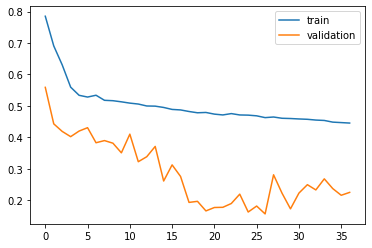


predict: [[31.91891918 22.49755757]]
real:      [[30.9 22.9]]

Train on 1003 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7355 - mean_squared_error: 0.8544 - val_loss: 1.0575 - val_mean_squared_error: 1.2959
Epoch 2/1000
 - 0s - loss: 0.6490 - mean_squared_error: 0.6818 - val_loss: 1.0507 - val_mean_squared_error: 1.2112
Epoch 3/1000
 - 0s - loss: 0.5700 - mean_squared_error: 0.5501 - val_loss: 0.9099 - val_mean_squared_error: 0.9126
Epoch 4/1000
 - 0s - loss: 0.5420 - mean_squared_error: 0.5033 - val_loss: 0.8976 - val_mean_squared_error: 0.9107
Epoch 5/1000
 - 0s - loss: 0.5288 - mean_squared_error: 0.4869 - val_loss: 0.8626 - val_mean_squared_error: 0.8395
Epoch 6/1000
 - 0s - loss: 0.5202 - mean_squared_error: 0.4749 - val_loss: 0.9034 - val_mean_squared_error: 0.9217
Epoch 7/1000
 - 0s - loss: 0.5177 - mean_squared_error: 0.4728 - val_loss: 0.8740 - val_mean_squared_error: 0.8810
Epoch 8/1000
 - 0s - loss: 0.5105 - mean_squared_error: 0.4675 - val_loss: 0.8841 - va

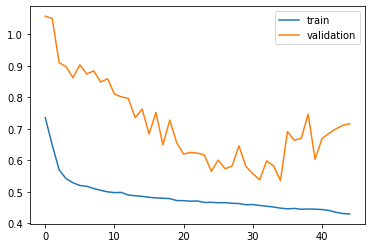


predict: [[32.30582126 22.68726233]]
real:      [[31.2 23.2]]

Train on 1002 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7447 - mean_squared_error: 0.8601 - val_loss: 1.0876 - val_mean_squared_error: 1.8617
Epoch 2/1000
 - 0s - loss: 0.6438 - mean_squared_error: 0.6733 - val_loss: 0.9656 - val_mean_squared_error: 1.5053
Epoch 3/1000
 - 0s - loss: 0.5766 - mean_squared_error: 0.5605 - val_loss: 0.7792 - val_mean_squared_error: 1.1936
Epoch 4/1000
 - 0s - loss: 0.5448 - mean_squared_error: 0.5110 - val_loss: 0.8063 - val_mean_squared_error: 1.1740
Epoch 5/1000
 - 0s - loss: 0.5341 - mean_squared_error: 0.4924 - val_loss: 0.8329 - val_mean_squared_error: 1.2405
Epoch 6/1000
 - 0s - loss: 0.5272 - mean_squared_error: 0.4832 - val_loss: 0.8112 - val_mean_squared_error: 1.2147
Epoch 7/1000
 - 0s - loss: 0.5186 - mean_squared_error: 0.4748 - val_loss: 0.8043 - val_mean_squared_error: 1.1889
Epoch 8/1000
 - 0s - loss: 0.5181 - mean_squared_error: 0.4698 - val_loss: 0.8074 - va

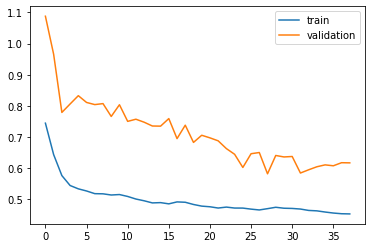


predict: [[32.61810048 22.77681721]]
real:      [[31.  21.1]]

Train on 1001 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7321 - mean_squared_error: 0.8680 - val_loss: 0.8411 - val_mean_squared_error: 1.0842
Epoch 2/1000
 - 0s - loss: 0.6327 - mean_squared_error: 0.6669 - val_loss: 0.8104 - val_mean_squared_error: 0.8631
Epoch 3/1000
 - 0s - loss: 0.5832 - mean_squared_error: 0.5768 - val_loss: 0.6717 - val_mean_squared_error: 0.6357
Epoch 4/1000
 - 0s - loss: 0.5569 - mean_squared_error: 0.5322 - val_loss: 0.5325 - val_mean_squared_error: 0.5251
Epoch 5/1000
 - 0s - loss: 0.5371 - mean_squared_error: 0.5029 - val_loss: 0.5228 - val_mean_squared_error: 0.4540
Epoch 6/1000
 - 0s - loss: 0.5286 - mean_squared_error: 0.4857 - val_loss: 0.5235 - val_mean_squared_error: 0.4799
Epoch 7/1000
 - 0s - loss: 0.5212 - mean_squared_error: 0.4792 - val_loss: 0.5103 - val_mean_squared_error: 0.4818
Epoch 8/1000
 - 0s - loss: 0.5119 - mean_squared_error: 0.4677 - val_loss: 0.5124 - va

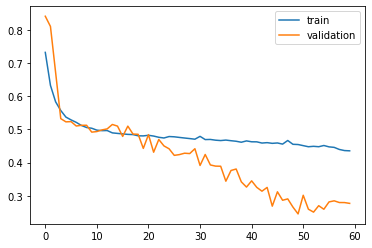


predict: [[32.37623032 22.65020336]]
real:      [[28.7 22.8]]

Train on 1000 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7803 - mean_squared_error: 0.9553 - val_loss: 0.9880 - val_mean_squared_error: 1.0153
Epoch 2/1000
 - 0s - loss: 0.6618 - mean_squared_error: 0.7145 - val_loss: 0.8153 - val_mean_squared_error: 0.6707
Epoch 3/1000
 - 0s - loss: 0.5804 - mean_squared_error: 0.5742 - val_loss: 0.5738 - val_mean_squared_error: 0.3321
Epoch 4/1000
 - 0s - loss: 0.5556 - mean_squared_error: 0.5255 - val_loss: 0.6374 - val_mean_squared_error: 0.4095
Epoch 5/1000
 - 0s - loss: 0.5390 - mean_squared_error: 0.5028 - val_loss: 0.6440 - val_mean_squared_error: 0.4193
Epoch 6/1000
 - 0s - loss: 0.5257 - mean_squared_error: 0.4895 - val_loss: 0.6230 - val_mean_squared_error: 0.3921
Epoch 7/1000
 - 0s - loss: 0.5131 - mean_squared_error: 0.4706 - val_loss: 0.6260 - val_mean_squared_error: 0.3978
Epoch 8/1000
 - 0s - loss: 0.5062 - mean_squared_error: 0.4623 - val_loss: 0.5593 - va

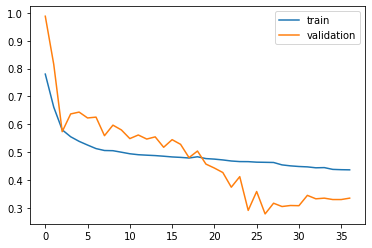


predict: [[32.60214478 22.81089319]]
real:      [[30.1 22.9]]



In [12]:
# to get index the last 30 days
days_to_predict = list(dataset.index[-30:])

standart_scaler = preprocessing.StandardScaler()
values_scaled = standart_scaler.fit_transform(values)
dataset_scaled = DataFrame(values_scaled)
dataset_scaled.index = dataset.index
dataset_scaled.columns = dataset.columns

plot_columns(values_scaled)

result = NCV(dataset_scaled, days_to_predict, standart_scaler)

In [13]:
y_hats = result[0]
y_tests = result[1]

metrics(y_hats, y_tests)

Maximum metrics
Test RMSE -------------------------- 2.271
Test VARIANCE ---------------------- -0.3127
Test MAX-ERROR --------------------- 7.2
Test MEAN-ABSOLUTE-ERROR ----------- 1.741
Test MEDIAN-ABSOLUTE-ERROR --------- 1.204

Accuracy
40.0% of predictions missed 1 point(s) or less
26.67% of predictions missed 2 point(s) or less
20.0% of predictions missed 3 point(s) or less
6.67% of predictions missed 4 point(s) or less
3.33% of predictions missed 5 point(s) or less

Minimum metrics
Test RMSE -------------------------- 0.8874
Test VARIANCE ---------------------- -0.06864
Test MAX-ERROR --------------------- 1.849
Test MEAN-ABSOLUTE-ERROR ----------- 0.704
Test MEDIAN-ABSOLUTE-ERROR --------- 0.4427

Accuracy
73.33% of predictions missed 1 point(s) or less
26.67% of predictions missed 2 point(s) or less
